<a href="https://colab.research.google.com/github/Ibraheem101/Made-With-ML/blob/main/notebooks/mwml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLOPs**

## **Setup**

### **Clone Github repository**

In [1]:
! git clone https://github.com/GokuMohandas/Made-With-ML.git

Cloning into 'Made-With-ML'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 134 (delta 19), reused 133 (delta 19), pack-reused 1
Receiving objects: 100% (134/134), 3.44 MiB | 14.84 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [53]:
! pwd

/content/Made-With-ML


In [2]:
import os
print(os.getcwd())

/content


In [3]:
import os
new_directory = "/content/Made-With-ML"
os.chdir(new_directory)

In [4]:
print(os.getcwd())

/content/Made-With-ML


In [5]:
import sys
sys.path.append('/content/Made-With-ML')

### **Install requirements**

In [7]:
! pip install --upgrade pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.0
    Uninstalling wheel-0.41.0:
      Successfully uninstalled wheel-0.41.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [8]:
pip install -r requirements.txt

  Obtaining dependency information for ipywidgets>=8 from https://files.pythonhosted.org/packages/b8/d4/ce436660098b2f456e2b8fdf76d4f33cbc3766c874c4aa2f772c7a5e943f/ipywidgets-8.1.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 61.2 MB/s eta 0:00:00
  Obtaining dependency information for ray[air]==2.6.0 from https://files.pythonhosted.org/packages/47/67/2716aad353da16321dfb0c1b03884d2202993dfd665922e7bd1f5d30f231/ray-2.6.0-cp310-cp310-manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.2 MB/s eta 0:00:00
     ━━

In [6]:
! pre-commit install
! pre-commit autoupdate

pre-commit installed at .git/hooks/pre-commit
Updating https://github.com/pre-commit/pre-commit-hooks ... [INFO] Initializing environment for https://github.com/pre-commit/pre-commit-hooks.
already up to date.


In [7]:
import os
import re
import json
import math
import nltk
import torch
import gensim
import random
import urllib
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [42]:
# Support for third party widgets
from google.colab import output
output.enable_custom_widget_manager()

### **Ray Setup**

In [8]:
import ray

In [9]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-08-09 06:28:16,481	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.12
Ray version:,2.6.0
Dashboard:,http://127.0.0.1:8265


In [10]:
ray.cluster_resources()

{'node:172.28.0.12': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 2.0,
 'object_store_memory': 3941376000.0,
 'memory': 7882752000.0}

In [11]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 0}

## **Data**

In [12]:
import pandas as pd

In [13]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",graph-learning


### **Data Splitting**

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
mlops                           63
reinforcement-learning          45
graph-learning                  33
time-series                     28
Name: count, dtype: int64

What are the criteria we should focus on to ensure proper data splits?
* Randomness
* Stratification (for imbalanced datasets)
* Sufficient data size in each subset
* Temporal data handling (for time-series data)
* Consistency across models
* Reproducibility with random seed
* Adequate validation set size for hyperparameter tuning
* Complete separation of the test set from training and validation data.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           764 non-null    int64 
 1   created_on   764 non-null    object
 2   title        764 non-null    object
 3   description  764 non-null    object
 4   tag          764 non-null    object
dtypes: int64(1), object(4)
memory usage: 30.0+ KB


In [17]:
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [18]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
mlops                           50
reinforcement-learning          36
graph-learning                  26
time-series                     23
Name: count, dtype: int64

In [19]:
val_df.tag.value_counts()

tag
natural-language-processing    62
computer-vision                57
mlops                          13
reinforcement-learning          9
graph-learning                  7
time-series                     5
Name: count, dtype: int64

In [20]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
mlops                           52
reinforcement-learning          36
graph-learning                  28
time-series                     20
Name: count, dtype: int64

### **Exploratory Data Analysis**

In [21]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [22]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('mlops', 63),
 ('reinforcement-learning', 45),
 ('graph-learning', 33),
 ('time-series', 28)]

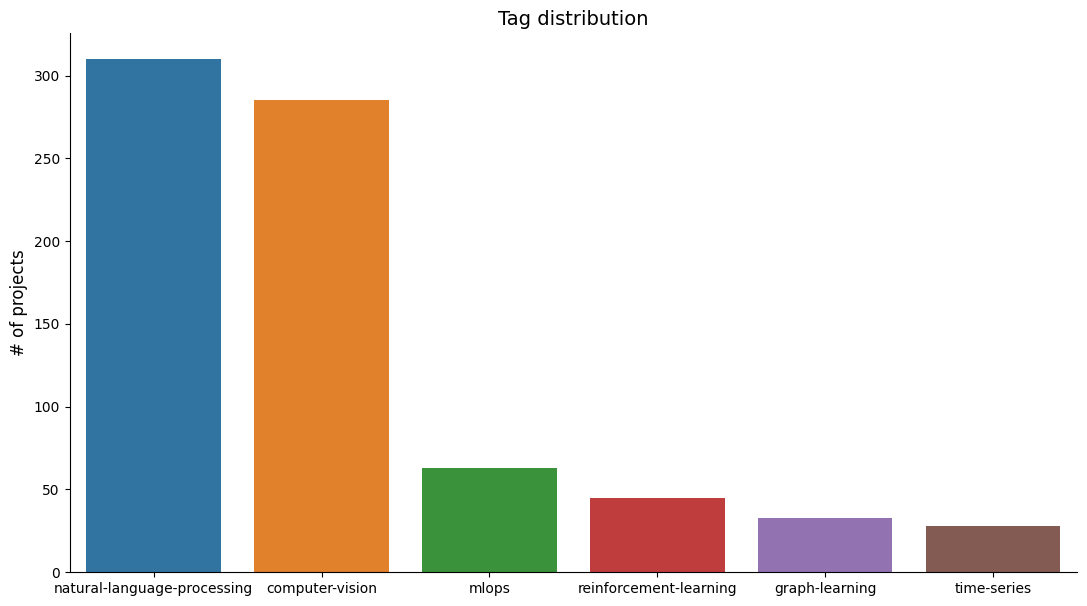

In [23]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(13, 7))
sns.barplot(x=list(tags), y=list(tag_counts))
sns.despine()
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()
# plt.xticks(rotation=45)

There's some data imbalance but we'll deal with that before modeling

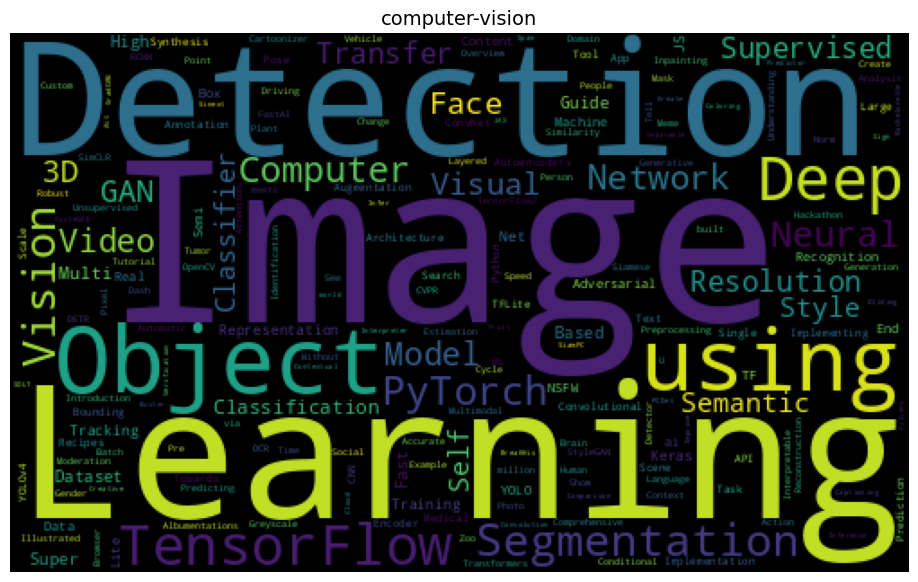

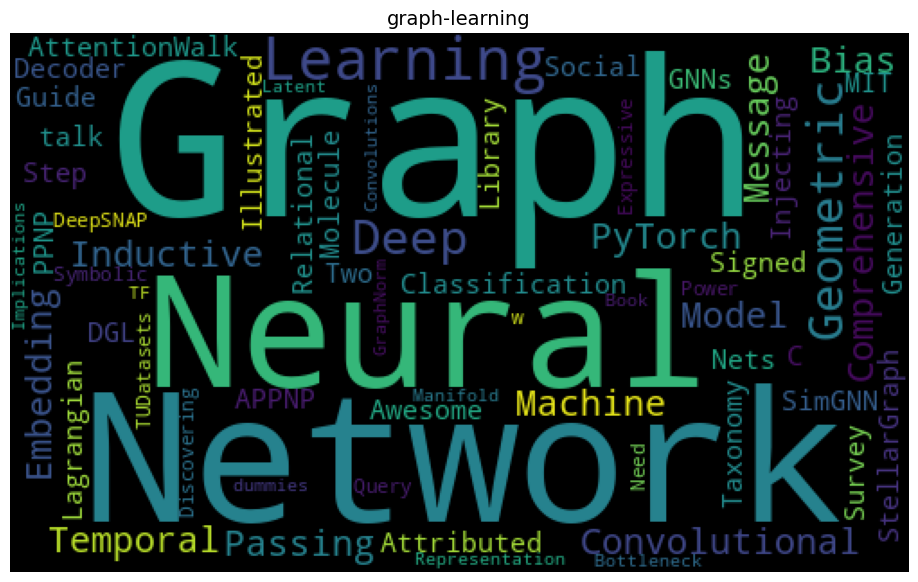

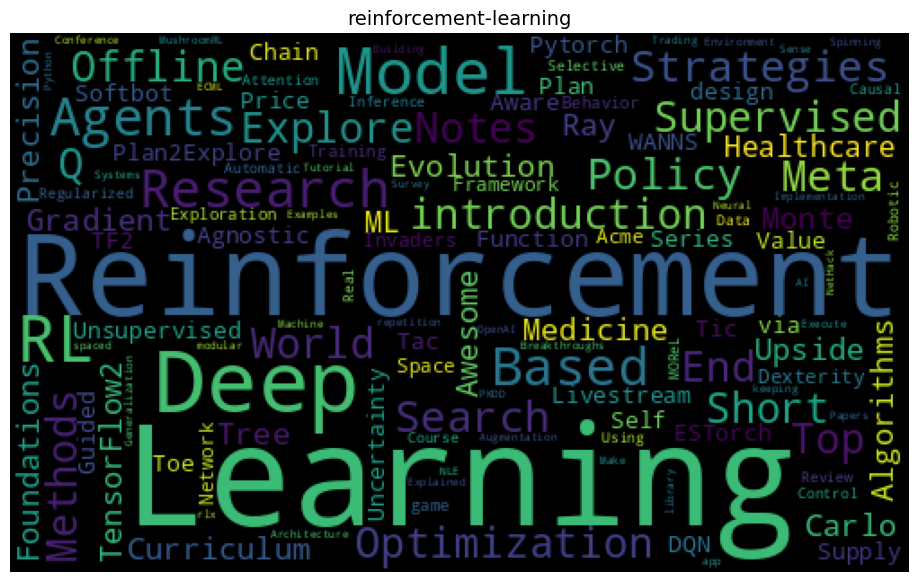

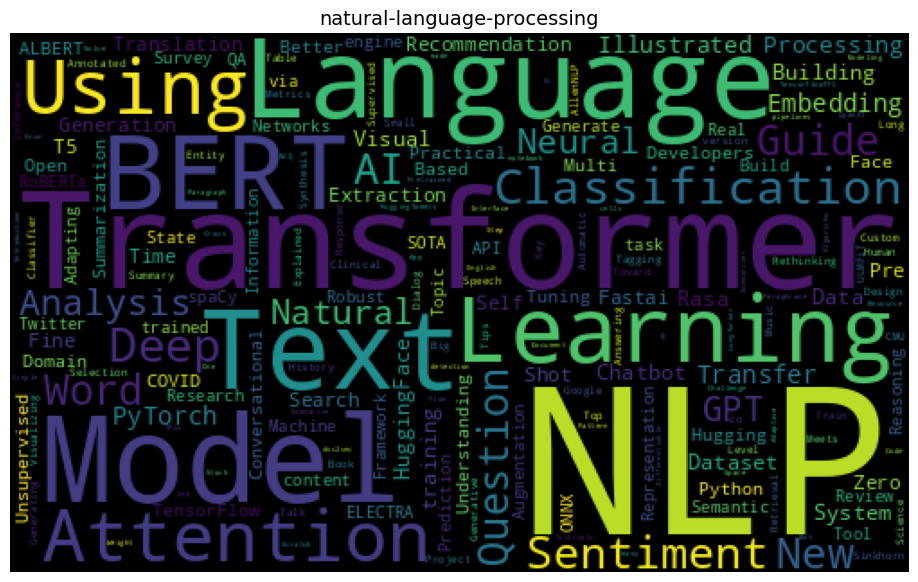

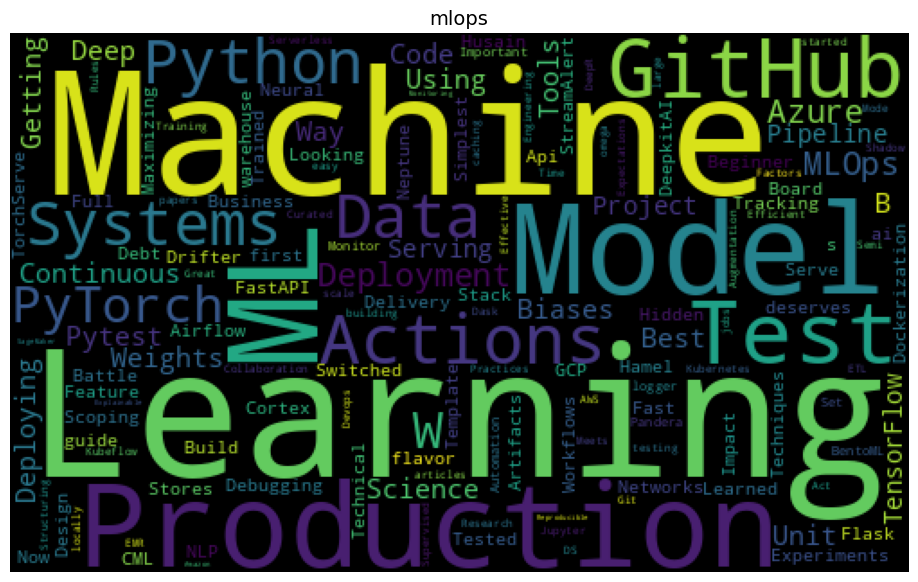

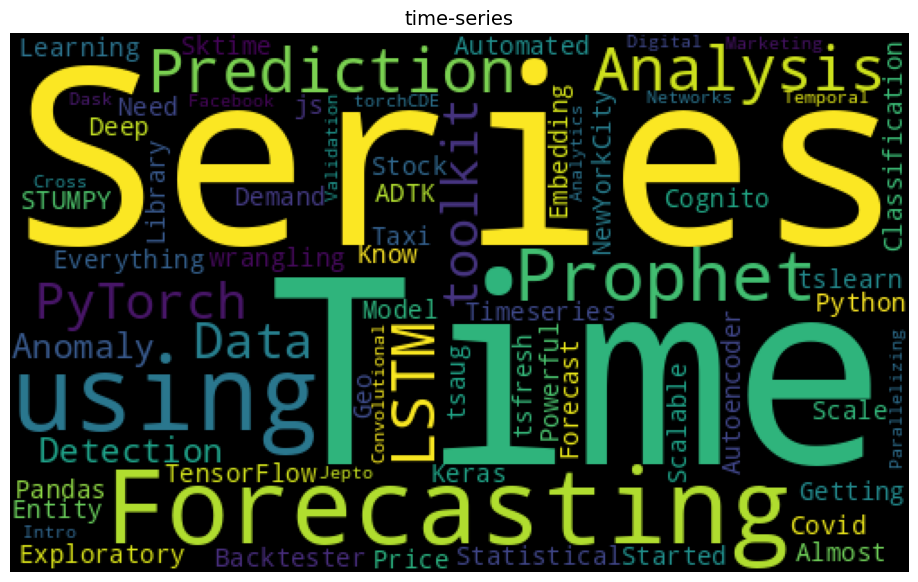

In [24]:
# Examine word distribution
# Create a list to store the generated WordCloud plots
cloud_plots = []

for tag in df['tag'].unique():
    plt.figure(figsize=(13, 7))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color='black', collocations=False,
        width=500, height=300).generate(" ".join(text)) #function requires a single string as input
    plt.axis("off")
    plt.imshow(cloud)
    plt.title(tag, fontsize=14)
    cloud_plots.append(plt)  # Store the current plot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=2, hspace=0.5)

# Display all the plots
plt.show()


### **Preprocessing**

In [25]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [26]:
df.iloc[0]

id                                                             6
created_on                                   2020-02-20 06:43:18
title          Comparison between YOLO and RCNN on real world...
description    Bringing theory to experiment is cool. We can ...
tag                                              computer-vision
Name: 0, dtype: object

#### **Feature engineering**

Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [27]:
df['text'] = df['title'] + ' ' + df['description']

#### **Cleaning**

In [28]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
def clean_text(text, stopwords = STOPWORDS):
    # lowercase
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text

In [30]:
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [31]:
df.head(2)

,id,created_on,title,description,tag,text
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision,comparison yolo rcnn real world videos bringin...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision,show infer tell contextual inference creative ...


In [32]:
# Drop unwanted columns
df.drop(columns = ['id', 'created_on', 'title', 'description'], errors='ignore')
df = df.dropna(subset=["tag"])  # drop nulls
df = df[['text', 'tag']]
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,graph-learning
3,awesome monte carlo tree search curated list m...,reinforcement-learning
4,attentionwalk pytorch implementation watch ste...,graph-learning


#### **Label Encoding**

In [33]:
tags = df.tag.unique().tolist()
num_classes = len(tags)

class_to_index = {tag : i for i, tag in enumerate(tags)}
class_to_index

{'computer-vision': 0,
 'graph-learning': 1,
 'reinforcement-learning': 2,
 'natural-language-processing': 3,
 'mlops': 4,
 'time-series': 5}

In [34]:
# Encode labels
df['tag'] = df['tag'].map(class_to_index)
df['tag'].iloc[:5]

0    0
1    0
2    1
3    2
4    1
Name: tag, dtype: int64

In [35]:
# Decoding function
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [36]:
index_to_class = {value : key for key, value in class_to_index.items()}
decode(df['tag'].iloc[:5], index_to_class)

['computer-vision',
 'computer-vision',
 'graph-learning',
 'reinforcement-learning',
 'graph-learning']

#### **Tokenize**

In [38]:
from transformers import BertTokenizer

In [39]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [43]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([0])}

Combine preprocessing operations

In [44]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [45]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  1845, 14454, ...,     0,     0,     0],
        [  102,  1834, 30120, ...,     0,     0,     0],
        ...,
        [  102,  1060,  2913, ...,     0,     0,     0],
        [  102, 10215,  1965, ...,     0,     0,     0],
        [  102,   934,  5038, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([3, 1, 3, 1, 3, 5, 3, 2, 3, 0, 3, 0, 0, 4, 0, 1, 3, 0, 3, 3, 0, 0,
        0, 4, 0, 4, 3, 3, 3, 0, 4, 3, 3, 0, 0, 3, 3, 5, 0, 0, 4, 0, 3, 0,
        3, 3, 0, 3, 5, 3, 3, 0, 3, 3, 5, 0, 0, 2, 4, 5, 3, 5, 4, 3, 3, 0,
        2, 3, 4, 4, 2, 3, 1, 3, 0, 2, 3, 3, 3, 0, 5, 3, 0, 0, 0, 0, 3, 3,
        3, 0, 3, 3, 4, 1, 0, 0, 0, 4, 0, 0, 4, 2, 0, 4, 3, 4, 0, 3, 3, 0,
        0, 3, 3, 3, 0, 3, 0, 5, 0

### **Distributed**

#### **Setup**

By default, the preserve_order option is set to False, which allows Ray to execute operations in parallel and potentially optimize the execution for better performance. However, when you set it to True, Ray will prioritize maintaining the order of data, which may result in slower performance but deterministic output

In [46]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True  # deterministic

In [47]:
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

2023-08-09 06:36:43,296	INFO read_api.py:374 -- To satisfy the requested parallelism of 4, each read task output will be split into 4 smaller blocks.
2023-08-09 06:36:43,334	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-08-09 06:36:43,342	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle]
2023-08-09 06:36:43,344	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-09 06:36:43,351	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

[{'id': 1151,
  'created_on': datetime.datetime(2020, 6, 3, 7, 25, 27),
  'title': 'Web Mining and Information theory',
  'description': 'Mining the Web and playing with Natural Language processing. Implementing Information retrieval System tasks. Going towards the NLP and Performing Machine Learning algorithms. Through these codes and problems, I have understood the information retrieval process of any search engine. These are very useful problems towards sentiment analysis.',
  'tag': 'natural-language-processing'}]

#### **Splitting**
Next, we'll split our dataset into our training and validation splits. Ray has a built-in train_test_split function but we're using a modified version so that we can stratify our split based on the tag column.

In [48]:
import sys
sys.path.append("..")
from madewithml.data import stratify_split

In [49]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2023-08-09 06:39:20,711	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2023-08-09 06:39:20,724	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-09 06:39:20,730	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

#### **Preprocessing**
One of the advantages of using Ray is that we won't have to change anything to our original Pandas-based preprocessing function we implemented in the previous lesson. Instead, we can use it directly with Ray's map_batches utility to map our preprocessing function across batches in our data in a distributed manner.

In [50]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2023-08-09 06:40:43,661	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2023-08-09 06:40:43,671	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-09 06:40:43,678	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

2023-08-09 06:40:51,517	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2023-08-09 06:40:51,526	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-09 06:40:51,529	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2023-08-09 06:41:22,318	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(4)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)]
2023-08-09 06:41:22,328	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2023-08-09 06:41:22,333	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/4 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/4 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/4 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/4 [00:00<?, ?it/s]

Running 0:   0%|          | 0/4 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/4 [00:00<?, ?it/s]

{'ids': array([  102,  4490,   318,  1965,  3725,  4081,  9774,  6502,  6733,
        4725,   965,  4490,   318,  3725,  5950,  1108, 12662,   103,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 2}
